In [10]:
import math
from scipy.sparse import csr_matrix
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from quantumScarsCheck import *
from quantumScarsPlotting import *

# task 1: make function that turns binary to decimal
def binToDeci(num):
    
    startBase = math.pow(2, len(num)-1)
    deciNum = 0

    for i in range(len(num)):
        deciNum += int(num[i]) * startBase
        startBase /= 2
        
    return int(deciNum)

# task 2: no consecutive ones in binary sequence
def binNoConsecOnesEfficient(N):

    def recursiveBin(n, prevNum, currNum):

        #print(currNum, 'b')
        
        if n == 0:
            listNoConsecOnes.append(currNum)
            return
        
        recursiveBin(n - 1, '0', currNum + '0')

        #print(currNum, 'a')
        
        if prevNum != '1':
            recursiveBin(n - 1, '1', currNum + '1')

    listNoConsecOnes = []
    recursiveBin(N, None, '')
    
    return listNoConsecOnes

# creates z2 state
def z2_initial(N):
    return ''.join('1' if i % 2 == 0 else '0' for i in range(N))

# task 3: sparse matrix set up
N = 15 # <-----------------------------------------------------------------------------------------------------------------------------
basisList = binNoConsecOnesEfficient(N)
basisMap = {bitStr: i for i, bitStr in enumerate(basisList)}
basisLen = len(basisList)
flippedList = []

row = []
column = []

# flip bit hashmap
flipMap = {'0': '1', '1': '0'}

for i in range(basisLen):

    # add padding so that search doesnt go out of range
    paddedBitStr = '0' + basisList[i] + '0'
    copyBit = list(paddedBitStr)

    # apply the sum of r P_r-1 * sigma_x * P_r+1 operator
    for j in range(1, N+1):
        
        if paddedBitStr[j-1] == '0' and paddedBitStr[j+1] == '0':
            copyBit[j] = flipMap[paddedBitStr[j]]
            flippedList.append(''.join(copyBit)[1:-1])
            copyBit = list(paddedBitStr)
        
    # adds row and column values for the sparse matrix
    for k in range(len(flippedList)):
        
        row.append(basisMap[flippedList[k]])
        column.append(i)
        
    flippedList.clear()

# list of ones for the sparse matrix
onesList = np.ones(len(row), dtype=int)

# create the sparse matrix and turn it into a Qobj
sparseHamiltonian = csr_matrix((onesList, (row, column)), shape=[basisLen, basisLen])
matrixHamiltonian = sparseHamiltonian.toarray()
matrixHamiltonian = qt.Qobj(matrixHamiltonian)

# diagonalize the sparse matrix
eigenvalues, eigenstates = matrixHamiltonian.eigenstates()

# initial state
z2_str = z2_initial(N)
z2_index = basisMap[z2_str]
psi0 = qt.basis(basisLen, z2_index)

# time evolution of sparse matrix
tlist = np.linspace(0, 400, 500)
evolState = qt.sesolve(matrixHamiltonian, psi0, tlist)

# inner product between conjugate of initial state and each eigenstate of sparse matrix
# amplitudes = []

# for states in evolState.states:
#     amplitudes.append(psi0.dag() * states)

# for states in eigenstates:
#     amplitudes.append(psi0.dag() * states)

# graph the amplitudes of above
# plt.figure()
# plt.plot(eigenvalues, np.abs(amplitudes)**2, ".")
# plt.yscale("log")
# plt.show()

# create H1 operator for QobjEvo!
copyBasis = basisList
diagH1 = []

# switches 0s to -1s and keeps 1s the same for the copyBasis
# appends to diagH1 the dot product between each bit string and the 0 -> -1 Z2 state
for i in range(basisLen):

    bitString = list(copyBasis[i])
    bitString = [int(i) for i in bitString]

    z2bitString = list(z2_initial(N))
    z2bitString = 2 * np.array([int(i) for i in z2bitString]) - 1

    diagH1.append(np.dot(2 * np.array(bitString) - 1, z2bitString))

# rows and columns lists for diagonal positions in H1
rowH1 = [i for i in range(basisLen)]
columnH1 = [i for i in range(basisLen)]

# creates sparse matrix with diagonals as diagH1 list
H1 = csr_matrix((diagH1, (rowH1, columnH1)), shape=[basisLen, basisLen])
H1 = qt.Qobj(H1)

# function for QobjEvo
def coeff(t, A, omega):
    return A * np.sin(omega * t)


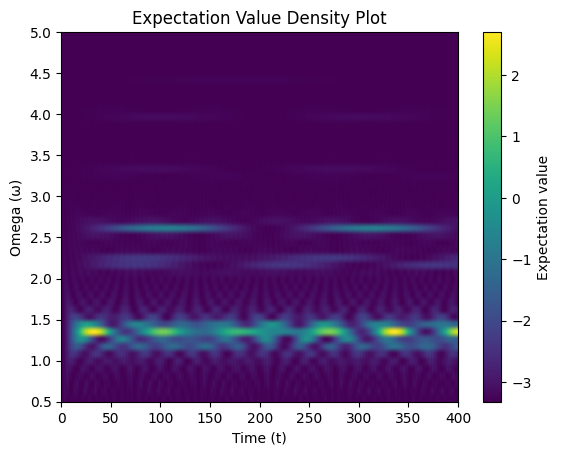

In [9]:

# plot the expectation values of the sparse matrix throughout time
wlist = np.linspace(0.5, 5.0, 50)
expectationVals = []
tempExpectation = []

for omega in wlist:

    args = {"A": 0.1, "omega": omega}
    H = qt.QobjEvo([matrixHamiltonian, [H1, coeff]], args=args) # create H using QobjEvo
    psi_t = qt.sesolve(H, eigenstates[0], tlist) # evolve the H through time
    tempExpectation = []

    for states in psi_t.states:

        val = states.dag() * matrixHamiltonian * states
        tempExpectation.append(val.real)

    expectationVals.append(tempExpectation)

plt.imshow(expectationVals,
           extent=[tlist.min(), tlist.max(), wlist.min(), wlist.max()],
           origin='lower',
           aspect='auto',
           cmap='viridis')
plt.colorbar(label="Expectation value")

plt.xlabel("Time (t)")
plt.ylabel("Omega (ω)")
plt.title("Expectation Value Density Plot")
plt.savefig("plots//expectDensityPlot.pdf")
plt.show()

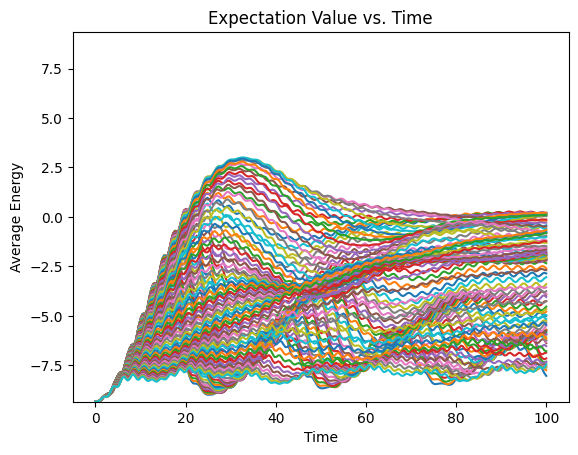

In [11]:
tlist_limited = np.linspace(0, 100, 250)
wlist_limited = np.linspace(1.0, 1.5, 100)
expectationVals_limited = []

plt.figure()
for omega in wlist_limited:

    args = {"A": 0.1, "omega": omega}
    H = qt.QobjEvo([matrixHamiltonian, [H1, coeff]], args=args) # create H using QobjEvo
    psi_t = qt.sesolve(H, eigenstates[0], tlist_limited) # evolve the H through time
    expectationVals_limited = []

    for states in psi_t.states:

        val = states.dag() * matrixHamiltonian * states
        expectationVals_limited.append(val.real)

    plt.plot(tlist_limited, expectationVals_limited, label=f"$\\omega = {omega:.2f}$")

plt.xlabel("Time")
plt.ylabel("Average Energy")
plt.title("Expectation Value vs. Time")
plt.ylim(eigenvalues[0], eigenvalues[-1]) # <--------------------------------------
# plt.legend()
plt.show()

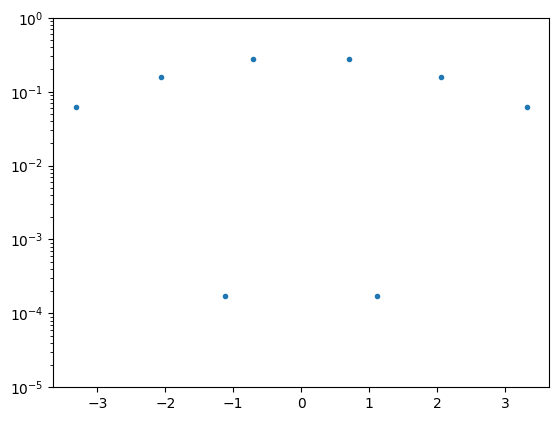

In [5]:
plotAmpEigenstatesZ2(matrixHamiltonian, psi0)

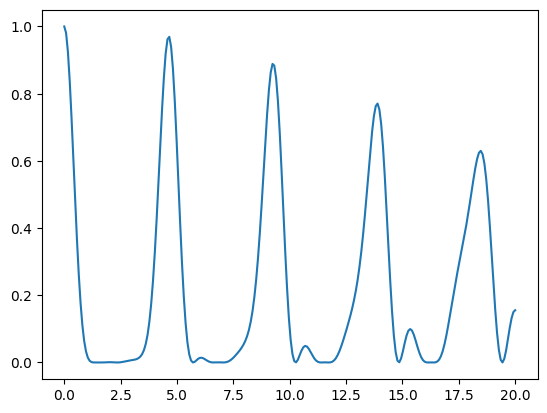

In [6]:
plotProbZ2Time(matrixHamiltonian, psi0)

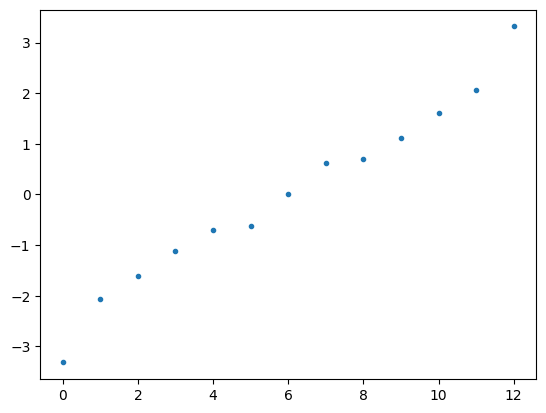

In [7]:
plotEigEnergies(matrixHamiltonian)